# 1. Cleaning and Geocoding

**Author**: Elba Gomez Navas 

Here, I clean, aggregate, and merge the various dataset extractions from our database at the unique 6-digit postal code level. I also extend our dataset by adding geolocation, specifically:

*  Latitude and longitude per postal code 
*  Neighbourhood in which the postal code resides. 
*  Local Health Area (LHA) in which the postal code resides

*Input files (raw files required to run code):* 

| File Name | Description | Location | 
|----------|:-------------:|:-------------:|
| **MANIFOLD_DOWNLOAD_.csv**|Five manifold files representing five different downloads from polaris | M:\PH-RPM\Elba\Data\Manifold_Downloads\ |
| **M:\PH-RPM\Elba\Data\PBI_Data_8-10-2018.xlsx** |Internal data with 2016,2017 donations among other variables  | M:\PH-RPM\Elba\Data\ |

*Resulting files:*

| File Name | Description | Location | 
|----------|:-------------:|:-------------:|
| **MANIFOLD_BC_ALL.csv**|contains manifold information + internal data by postal code | M:\PH-RPM\\Elba\\Data\\MANIFOLD_BC_ALL.csv |
| **Geocoded_MANIFOLD_BC_ALL_2.csv** |contains all postal codes with their respective lat/long and neighbourhood |  |


In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import sqlalchemy as sql
import zipfile
import urllib as rq
import geopandas as gpd #for geomapping analysis
import requests #making url requests 
from io import BytesIO, StringIO
import re
import utm #for geomapping
import json #for geomapping 

### I. Basic Merging and Cleaning 

In [2]:
#Uploading  Manifold extracts
data1 = pd.read_csv("M:\PH-RPM\Elba\Data\Manifold_Downloads\MANIFOLD_DOWNLOAD_1.csv")
data2 = pd.read_csv("M:\PH-RPM\Elba\Data\Manifold_Downloads\MANIFOLD_DOWNLOAD_2.csv")
data3 = pd.read_csv("M:\PH-RPM\Elba\Data\Manifold_Downloads\MANIFOLD_DOWNLOAD_3.csv")
data4 = pd.read_csv("M:\PH-RPM\Elba\Data\Manifold_Downloads\MANIFOLD_DOWNLOAD_4.csv")
data5 = pd.read_csv("M:\PH-RPM\Elba\Data\Manifold_Downloads\MANIFOLD_DOWNLOAD_5.csv")

#Renaming postal code to match what's on file
data2 = data2.rename(columns={'Postal Code': 'Postal_Code'})
data3 = data3.rename(columns={'Postal Code': 'Postal_Code'})
data4 = data4.rename(columns={'Postal Code': 'Postal_Code'})
data5 = data5.rename(columns={'Postal Code': 'Postal_Code'})

#Renaming data5 columns to differentiate from useless columns in other datasets
data5.head()
data5 = data5.rename(columns={'Postal Code': 'Postal_Code', '35 to 44 years-Count-PC': 'Tot_Priv_HH_Age_35-44',\
                    '45 to 54 years-Count-PC':'Tot_Priv_HH_Age_45-54',\
                    '55 to 64 years-Count-PC':'Tot_Priv_HH_Age_55-64',\
                    '65 to 74 years-Count-PC': 'Tot_Priv_HH_Age_65-74',\
                     'Under 25 years-Count-PC':'Tot_Priv_HH_Age_u_25',\
                     '25 to 34 years-Count-PC': 'Tot_Priv_HH_Age_25-34', \
                    '75 years and over-Count-PC': 'Tot_Priv_HH_Age_75_o'})
#MERGING 
result_key = data1.merge(data2, on='Postal_Code', how='left')
result_key_1= result_key.merge(data3, on='Postal_Code', how='left')
result_key_2= result_key_1.merge(data4, on='Postal_Code', how='left')
result_final= result_key_2.merge(data5, on='Postal_Code', how='left')
result_final.to_csv('M:\PH-RPM\\Elba\\Data\\MANIFOLD_MERGED.csv')

In [3]:
#Renaming Household Income Data
result_final = result_final.rename(columns={'Household with income $0 - $4,999-Count-PC': 'HH_Inc_1', \
                            'Household with income $5,000 - $9,999-Count-PC': 'HH_Inc_2',\
                            'Household with income $10,000 - $14,999-Count-PC': 'HH_Inc_3' , \
                            'Household with income $15,000 - $19,999-Count-PC': 'HH_Inc_4', \
                            'Household with income $20,000 - $29,999-Count-PC': 'HH_Inc_5',\
                            'Household with income $30,000 - $39,999-Count-PC': 'HH_Inc_6', \
                            'Household with income $40,000 - $49,999-Count-PC': 'HH_Inc_7', \
                            'Household with income $50,000 - $59,999-Count-PC': 'HH_Inc_8', \
                            'Household with income $60,000 - $79,999-Count-PC': 'HH_Inc_9',\
                            'Household with income $80,000 - $99,999-Count-PC': 'HH_Inc_10', \
                            'Household with income $100,000 - $124,999-Count-PC': 'HH_Inc_11',\
                            'Household with income $125,000 - $149,999-Count-PC' : 'HH_Inc_12',\
                            'Household with income $150,000 and over-Count-PC' : 'HH_Inc_13'})

In [4]:
#list(result_final) 

In [5]:
data = result_final[['Postal_Code','Population_Total','Pop_15_plus','Dwellings_Tot','ChildCount',\
'Median_HH_Income','Health_Care_Spending','Financial_Services','Gifts_Money',\
'Charity_Contributions','Retirement_Savings','HH_Inc_1', 'HH_Inc_2', 'HH_Inc_3', \
'HH_Inc_4', 'HH_Inc_5', 'HH_Inc_6', 'HH_Inc_7', 'HH_Inc_8', 'HH_Inc_9', 'HH_Inc_10',\
'HH_Inc_11', 'HH_Inc_12', 'HH_Inc_13', 'Median value of dwellings $', \
'Median monthly shelter costs for owned dwellings ($)',\
'Average family income ($)', 'Owned-Count-PC', 'Rented-Count-PC','Band housing-Count-PC_y',\
'Tot_Priv_HH_Age_35-44','Tot_Priv_HH_Age_45-54', 'Tot_Priv_HH_Age_55-64','Tot_Priv_HH_Age_65-74',\
'Tot_Priv_HH_Age_25-34','Tot_Priv_HH_Age_u_25','Tot_Priv_HH_Age_75_o']]
data.to_csv('M:\PH-RPM\\Elba\\Data\\MANIFOLD_MERGED_CLEANED.csv')

In [6]:
#Importing Foundation data for 2016-2017 and aggregating by postal code
foundation = pd.read_excel("M:\PH-RPM\Elba\Data\PBI_Data_8-10-2018.xlsx")
foundation = foundation.rename(columns={'ConcatPC': 'Postal_Code'})
found = foundation[['2017','2016','Postal_Code']]
grouped = found.groupby('Postal_Code')
foundation_donations = grouped.agg(np.sum)
foundation_donations.head()

,2017,2016
Postal_Code,,
L4J3N8,0.0,250.0
T9J1L8,0.0,50.0
V0A1E0,50.0,95.0
V0A1G0,400.0,100.0
V0A1H0,3180.0,5430.0


In [7]:
#Merging foundation and manifold data
data = data.merge(foundation_donations, on='Postal_Code', how='left')
data.tail()
data.to_csv('M:\PH-RPM\\Elba\\Data\\MANIFOLD_BC_ALL.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95002 entries, 0 to 95001
Data columns (total 39 columns):
Postal_Code                                             95002 non-null object
Population_Total                                        95002 non-null int64
Pop_15_plus                                             95002 non-null int64
Dwellings_Tot                                           95002 non-null int64
ChildCount                                              95002 non-null int64
Median_HH_Income                                        95002 non-null int64
Health_Care_Spending                                    95002 non-null int64
Financial_Services                                      95002 non-null int64
Gifts_Money                                             95002 non-null int64
Charity_Contributions                                   95002 non-null int64
Retirement_Savings                                      95002 non-null int64
HH_Inc_1                                   

###  II. Here, we use Google API key to add lat/long to each postal code 

In [ ]:
#https://developers.google.com/maps/documentation/javascript/get-api-key#standard-auth#
%matplotlib inline
#given a location via string, return lat lng.
def gc(location):
    
    #query the google geocode api for lat lng
    data = requests.get("https://maps.googleapis.com/maps/api/geocode/json?address=" + location + "&key=" + "add key number here").json()
    
    if len(data['results']) > 0:
        
        #if there's a result, return the first one.
        return [data['results'][0]['geometry']['location']['lat'], data['results'][0]['geometry']['location']['lng']]
    
    else:
        #if no result is found, return an empty list
        return [0,0]

In [ ]:
#Iterate over all values in Postal Code column to assign lat long 
def get_latlon(row):
    #obtain the lat/long for a row in assigned column (postal code)
    tup = gc(row.iloc[0])
    return pd.Series(tup[:2])

data[['Lat','Long']] = data[['Postal_Code']].apply(get_latlon , axis=1)
data.to_csv('M:\PH-RPM\\Elba\\Data\\Geocoded_MANIFOLD_BC_ALL_2.csv')

###  III. Now, we want to assign a neighbourhood to each postal code. For that we use neighbourhood shapefiles for  all neighbourhoods  per city in BC 

First, we convert our csv data to a geodataframe:

In [9]:
import geopandas
import geopandas.tools
import utm
from shapely.geometry import Point
from json import dumps
import pandas as pd

#Import data (already clean)
data= pd.read_csv('M:\PH-RPM\\Elba\\Data\\Geocoded_MANIFOLD_ALL.csv')

#Create the geometry column for the coordinates
data["geometry"] = data.apply(lambda row: Point(row['Long'], row['Lat']), axis=1)
#data.head()

In [10]:
#PLACE POSTAL CODES WITHIN NEIGHBOURHOOD (so that we can link the geojson file)
#First, we want to convert our shapefile to a geojson file 
#https://gis.stackexchange.com/questions/190903/assign-a-point-to-polygon-using-pandas-and-shapely
import geopandas
import geopandas.tools
import utm
from shapely.geometry import Point
from json import dumps

#Import data (already clean)
data= pd.read_csv('M:\PH-RPM\\Elba\\Data\\Geocoded_MANIFOLD_ALL.csv')

#Create the geometry column for the coordinates
data["geometry"] = data.apply(lambda row: Point(row['Long'], row['Lat']), axis=1)

#Convert to a GeoDataFrame
data = geopandas.GeoDataFrame(data, geometry="geometry")
data.crs = {'init': 'epsg:26910'}

data[['Postal_Code', 'Lat', 'Long','geometry']].head()

,Postal_Code,Lat,Long,geometry
0,T9J1L8,56.723233,-111.393454,POINT (-111.3934539 56.7232329)
1,V6M3B7,49.239210,-123.139666,POINT (-123.1396659 49.2392105)
2,V6M3B5,49.240633,-123.139662,POINT (-123.1396617 49.24063289999999)
3,V6M3G1,49.240367,-123.142134,POINT (-123.1421342 49.2403674)
4,V6M3B3,49.241149,-123.139715,POINT (-123.1397153 49.2411485)


Then, we import and inspect the geojson file that has the neighbourhoods

In [11]:
# Declare the coordinate system for the places GeoDataFrame
# GeoPandas doesn't do any transformations automatically when performing
# the spatial join. The layers are already in the same CRS (WGS84) so no
# transformation is needed.
#http://spatialreference.org/ref/epsg/nad83-bc-albers/
#https://stackoverflow.com/questions/42751748/using-python-to-project-lat-lon-geometry-to-utm 
#https://pypi.org/project/utm/
#https://stackoverflow.com/questions/30014684/pandas-apply-utm-function-to-dataframe-columns

# Load the neighbourhood polygons
neighbourhoods = geopandas.GeoDataFrame.from_file("C:\\Users\\egomez\\Desktop\\all_bc.geojson")
neighbourhoods.crs = {'init': 'epsg:26910'}

# Let's quickly look at the shapefile to make sure it's what we want and to do a quick exploration 
#Note that (1) this is not reprojected to UTM and (2) this has not been corrected for waterbodies 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
neighbourhoods.plot(ax = ax);

In [12]:
#Drop all columns except the neighbourhood name, neighbourhood code, and polygon geometry
neighbourhoods = neighbourhoods[["N_CODE","N_NAME", "geometry"]]

#Perform the spatial join
result = geopandas.tools.sjoin(data, neighbourhoods, how="inner", op="within")

#show result 
result[['Postal_Code', 'Lat', 'Long','geometry', "N_NAME", "geometry"]].head()

,Postal_Code,Lat,Long,geometry,N_NAME,geometry
1,V6M3B7,49.239210,-123.139666,POINT (-123.1396659 49.2392105),Shaughnessy,POINT (-123.1396659 49.2392105)
2,V6M3B5,49.240633,-123.139662,POINT (-123.1396617 49.24063289999999),Shaughnessy,POINT (-123.1396617 49.24063289999999)
3,V6M3G1,49.240367,-123.142134,POINT (-123.1421342 49.2403674),Shaughnessy,POINT (-123.1421342 49.2403674)
4,V6M3B3,49.241149,-123.139715,POINT (-123.1397153 49.2411485),Shaughnessy,POINT (-123.1397153 49.2411485)
5,V6M3B9,49.238304,-123.139723,POINT (-123.1397234 49.2383039),Shaughnessy,POINT (-123.1397234 49.2383039)


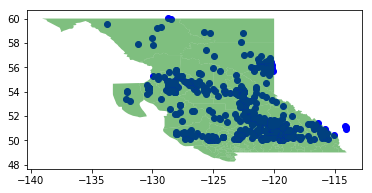

In [13]:
#Roughly Removing points outside of BC 
data_1 = data[(data.Lat >50) & (data.Long <-114)]

ax = data_1.plot(color='blue');
neighbourhoods.plot(ax=ax, color='green', alpha=0.5);

In [15]:
result.to_csv('M:\PH-RPM\\Elba\\Data\\Geocoded_MANIFOLD_BC_ALL_2.csv')